## 第一題 [myknn_regressor]

#### Q1.1

In [16]:
import numpy as np

class myknn_regressor():
    def __init__(self, n_neighbors = 10, mean_type = "equal_weight"):
        """mean_type can be equal_weight or remove_outliers.
                              equal_weight use the same weight for all neighbors.
                              remove_outliers remove neighbors out in [Q1 - 1.5 IQR, Q3 - 1.5IQR].  This is how box plot  detect outliers"""
        self.k = n_neighbors
        self.mean_type = mean_type        

    def fit(self, x_train, y_train):
        self.x_train = x_train
        self.y_train = y_train

    def predict(self, x_test):
        """use remove_outliers only if k>=10"""
        ypred = []
        for idx in range(x_test.shape[0]): 
            dist = self.x_train - x_test[idx]
            mse = np.sum(dist ** 2, axis = 1)
            
            pred = self.y_train[np.argsort(mse)[:self.k]]

            if (self.mean_type == "equal_weight") or self.k < 10:
                res = pred.mean()
            else:
                q1 = np.quantile(pred, 0.25)
                q3 = np.quantile(pred, 0.75)
                iqr = q3 - q1
                lower = q1 - 1.5 * iqr
                upper = q3 + 1.5 * iqr
                pred = pred[(pred >= lower) & (pred <= upper)]
                res = pred.mean()

            ypred.append(res)
        return(np.array(ypred))

#### Q1.2

In [18]:
import pickle
from sklearn import preprocessing
import numpy as np

#Load data
with open('msd_data1.pickle', 'rb') as fh1:
    msd_data = pickle.load(fh1)

doscaling = 1

if (doscaling == 1):
    xscaler = preprocessing.StandardScaler().fit(msd_data['X_train'])
    #standardize feature values
    X_train = xscaler.transform(msd_data['X_train'])
    X_test = xscaler.transform(msd_data['X_test'])
else:
    X_train = msd_data['X_train']
    X_test = msd_data['X_test']

Y_train = msd_data['Y_train']
Y_test = msd_data['Y_test']

myknn = myknn_regressor(20, "equal_weight")
myknn.fit(X_train, Y_train)
ypred = myknn.predict(X_test)
rmse = np.sqrt(np.mean(np.square(Y_test - ypred)))

print("RMSE = ", rmse)
print("The first 20 predictions are:\n", ypred[0:20])

RMSE =  10.25126451549596
The first 20 predictions are:
 [1993.35 1993.8  2000.65 1991.5  1992.8  1998.5  1988.1  1991.65 2002.25
 2003.   2000.5  1998.65 1995.55 1997.2  1995.05 1997.4  1992.15 2000.45
 2003.2  1995.75]


#### Q1.3

In [19]:
myknn = myknn_regressor(20, "remove_outliers")
myknn.fit(X_train, Y_train)
ypred = myknn.predict(X_test)
rmse = np.sqrt(np.mean(np.square(Y_test - ypred)))

print("RMSE = ", rmse)
print("The first 20 predictions are:\n", ypred[0:20])

RMSE =  10.212572466080376
The first 20 predictions are:
 [1993.35       1993.8        2000.65       1992.73684211 1992.8
 2000.         1988.1        1991.65       2002.25       2003.94736842
 2000.5        2000.94444444 1995.55       1997.2        1998.61111111
 1997.4        1992.15       2003.83333333 2003.2        1995.75      ]


## 第二題 [Tuning the Hyper-parameter]

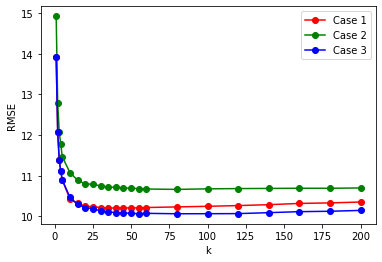

In [5]:
%matplotlib inline
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor

m = np.mean(X_train, axis = 0)
s = np.std(X_train, axis = 0)
scaled_xtrain = (X_train - m) / s
scaled_xtest = (X_test - m) / s

K = [1,2,3,4,5,10,15,20,25,30,35,40,45,50,55,60,80,100,120,140,160,180,200]

###############first case

RMSE = []
for k in K:
    knn = KNeighborsRegressor(n_neighbors = k)
    knn.fit(scaled_xtrain, Y_train)
    ypred = knn.predict(scaled_xtest)

    RMSE.append(np.sqrt(np.mean((Y_test - ypred) ** 2)))
plt.plot(K, RMSE, color = 'r', label = 'Case 1', linestyle = 'solid', marker = 'o')

###############second case
RMSE = []
for k in K:
    knn = KNeighborsRegressor(n_neighbors = k)
    knn.fit(X_train, Y_train)
    ypred = knn.predict(X_test)

    RMSE.append(np.sqrt(np.mean((Y_test - ypred) ** 2)))
plt.plot(K, RMSE, color = 'g', label = 'Case 2', linestyle = 'solid', marker = 'o')

###############third case
RMSE = []
for k in K:
    myknn = myknn_regressor(k, "remove_outliers")
    myknn.fit(scaled_xtrain, Y_train)
    ypred = myknn.predict(scaled_xtest)

    RMSE.append(np.sqrt(np.mean((Y_test - ypred) ** 2)))
plt.plot(K, RMSE, color = 'b', label = 'Case 3', linestyle = 'solid', marker = 'o')


plt.xlabel('k')
plt.ylabel('RMSE')
plt.legend()
plt.show()

#### Observation:
**由圖可見，基本上就RMSE來說，myknn的表現都是比sklearn的KNeighborsRegressor來得好，應是因為myknn有剔除outliers，以此降低極端值對於data的影響。而case1之所以又比case2好，是因為我們對於資料先進行了標準化以提升精確度。更進一步觀察RMSE，以case3來說，在k=15之前是急劇下降，而後緩慢下降，又以k=55左右降到最低，而後緩慢上升。若單就RMSE來看，k=55似乎是最好的k值。

## 第三題 [Lasso Regression]

#### Q3.1

![text](hw1_3_1.jpg)

#### Q3.2

In [5]:
import numpy as np

class mylasso():
    def __init__(self, lamcoef = 0.1, max_iter=1000, tol=1e-6, const_regu = False):
        self.lamcoef = lamcoef
        self.max_iter = max_iter
        self.tol = tol
        self.const_regu = False
        self.train_loss = 0

    def fit(self, x_train, y_train, winit = "ridge", keep_traindata = True, verbose = False):
        self.x_train = np.concatenate((x_train, np.ones((x_train.shape[0], 1))), 1)
        self.y_train = y_train
        num = [x_train.shape[0], x_train.shape[1], x_train.shape[1]+1] #0:data_num; 1:feature num; 2:num after adding bias term
#         print("*" * 20, num[2])
        #initialize w  
        x_square = self.x_train.T @ self.x_train
#         print(x_square)
        for i in range(x_square.shape[0]):
            x_square[i][i] = x_square[i][i] + self.lamcoef * num[0]
#         print(index)
        w = np.linalg.inv(x_square) @ self.x_train.T @ self.y_train
#         print(w)
        
        best_loss = 100000000
        last_loss = best_loss
        best_w = np.zeros((num[2]))
        
        for i in range(self.max_iter):            
            for j in range(num[2]):
                idx = [i for i in range(num[2]) if i!=j] 
                wj_star = np.sum((self.y_train - (self.x_train[:, idx] @ w[idx])) * self.x_train[:,j]) / np.sum(self.x_train[:,j] ** 2)
#                 print(wj_star)
                wj_new = wj_star
                d = self.lamcoef * num[0]  / np.sum(self.x_train[:,j] ** 2)
                
                if j < num[1] or (j == (num[1]) and self.const_regu == False):
                    if wj_star - d > 0:
                        wj_new = wj_star - d
                    elif wj_star + d < 0:
                        wj_new = wj_star + d
                    else:
                        wj_new = 0.0
                w[j] = wj_new
#             assert(False)
            pred = self.x_train @ w
            loss = 0.5 * (((self.y_train - pred)**2).mean()) + self.lamcoef * np.sum(abs(w))
#             print(loss)
            
            if best_loss > loss:
                best_loss = loss
                best_w = w
                    
            if abs(last_loss - loss) < self.tol:
                self.weight = best_w                
                self.coef_ = best_w[:-1]
                self.intercept_ = best_w[-1]
                self.train_loss = best_loss
                break
                
            last_loss = loss
        
        if keep_traindata == False:
            del self.x_train
            del self.y_train
            
    def predict(self, x_test):
        add_x_test = np.concatenate((x_test, np.ones((x_test.shape[0], 1))), 1)
        return add_x_test @ self.weight
        

#### Q3.3

In [12]:
#load the dataset, and create normalized and raw features. 
import pickle
from sklearn import preprocessing
import numpy as np
np.set_printoptions(suppress=True)

#Load data
with open('msd_data1.pickle', 'rb') as fh1:
    msd_data = pickle.load(fh1)

xscaler = preprocessing.StandardScaler().fit(msd_data['X_train'])
#standardize feature values
X_train_sd = xscaler.transform(msd_data['X_train'])
X_test_sd = xscaler.transform(msd_data['X_test'])

#outcome values
Y_train = msd_data['Y_train']
Y_test = msd_data['Y_test']

model = mylasso()
model.fit(X_train_sd, Y_train)
ypred_train = model.predict(X_train_sd)

print("Training loss:", model.train_loss)
print('\n')
print("Training RMSE:", (((Y_train - ypred_train) ** 2).mean()) ** 0.5)
print('\n')
print("Training MAE:", abs(Y_train - ypred_train).mean())
print('\n')
print("Intercept: ", model.intercept_)
print('\n')
print("Feature weights:", model.coef_)
print('\n')
print("Number of nonzero weights:", np.sum(model.coef_ != 0))

Training loss: 249.71000390933378


Training RMSE: 9.720218859559226


Training MAE: 7.004042396846557


Intercept:  1998.1660000000002


Feature weights: [ 4.65134347 -2.45779178 -1.06476309  0.         -0.34181357 -2.94500832
  0.         -0.39954223 -0.4263976   0.         -0.23519769 -0.39519543
  0.50442538  0.         -0.33734152  0.61077412  0.15734524  0.42529548
  0.43505058  1.12723149  0.40668494  0.          1.78186707  0.
 -0.1683647   0.07849856  0.66009984  0.01202792  0.15449625  0.
 -0.21787825 -0.2217945   0.         -0.00249707 -0.01755465 -0.26178941
  0.          0.29018409  0.34854301  0.         -0.26109129 -0.14423235
 -0.01040839  0.03522261 -0.03989073  0.          0.00319364 -0.17679486
  0.          0.06468757  0.27153098  0.          0.          0.
  0.          0.         -0.63658183  0.2386218  -0.18962539  0.
 -0.18889307  0.         -0.13595832  0.0611913  -0.26622051  0.
  0.          0.         -0.03143042  0.         -0.19345723  0.01235967
  0.20719

In [7]:
ypred_test = model.predict(X_test_sd)
print("Prediction of first five data ", ypred_test[0:5])
print("Test RMSE = ", (((Y_test - ypred_test) ** 2).mean()) ** 0.5)
print("Test MAE = ", abs(Y_test - ypred_test).mean())

Prediction of first five data  [1991.83431184 1998.97435408 2001.64695845 1991.20534314 1994.32244083]
Test RMSE =  9.650110579516506
Test MAE =  6.943703467805912


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

lam_list = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2]

param = []
for lam in lam_list:
    model = mylasso(lamcoef = lam)
    model.fit(X_train_sd, Y_train)
    ypred_train = model.predict(X_train_sd)
    rmse_train = (((Y_train -  ypred_train) ** 2).mean()) ** 0.5
    ypred_test = model.predict(X_test_sd)
    rmse_test = (((Y_test - ypred_test) ** 2).mean()) ** 0.5    
    param.append({'lambda': lam, 'train_loss': model.train_loss, 'num_nonzero':  np.sum(model.coef_ != 0), 'avg_size': abs(model.coef_).mean(), 'training_rmse': rmse_train, 'test_rmse': rmse_test})
    
df = pd.DataFrame(param)
df

,lambda,train_loss,num_nonzero,avg_size,training_rmse,test_rmse
0,0.0001,46.770287,90,0.470461,9.650516,9.644318
1,0.0005,47.586510,90,0.469211,9.650519,9.643936
2,0.0010,48.606725,90,0.467651,9.650531,9.643452
3,0.0050,56.765975,88,0.455628,9.650869,9.640304
4,0.0100,66.959436,87,0.442849,9.651768,9.636844
5,0.0500,148.329441,76,0.363834,9.672786,9.627032
6,0.1000,249.710004,59,0.294675,9.720219,9.650111
7,0.5000,1055.383688,16,0.120022,10.109371,10.021225
8,1.0000,2057.655324,4,0.042175,10.638945,10.548062
9,2.0000,4056.024131,1,0.004266,11.200386,11.141073


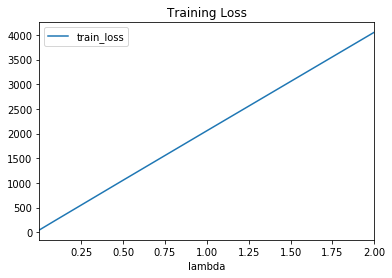

In [40]:
df.plot(x = 'lambda', y ='train_loss', title = 'Training Loss')

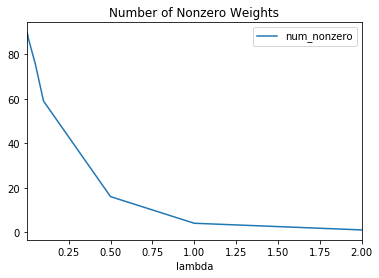

In [36]:
df.plot(x = 'lambda', y ='num_nonzero', title = 'Number of Nonzero Weights')

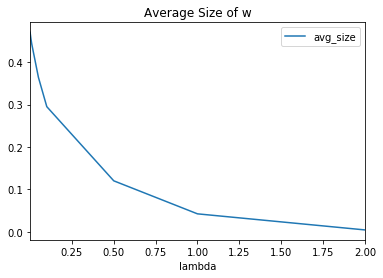

In [37]:
df.plot(x = 'lambda', y ='avg_size', title = "Average Size of w")

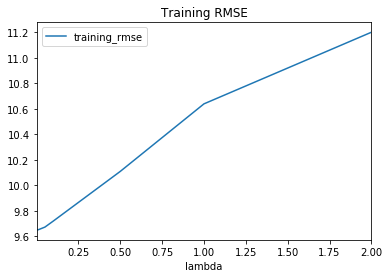

In [38]:
df.plot(x = 'lambda', y = 'training_rmse', title = "Training RMSE")

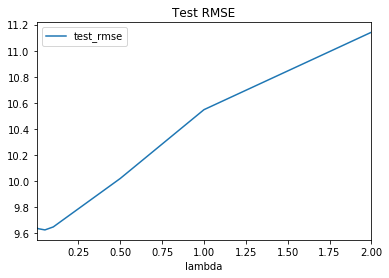

In [39]:
df.plot(x = 'lambda', y = 'test_rmse', title = "Test RMSE")

## Observations:
* Training Loss與Training RMSE會隨著Lambda上升而上升，而Number of Nonzero Wegiths與Average Wegith Size則會隨著Lambda上升而下降。
* Test RMSE會隨著Lambda上升而先下降再上升。